In [2]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector
import numpy as np
import random
import math
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector

     |████████████████████████████████| 4.8 MB 20.7 MB/s 
     |████████████████████████████████| 19.2 MB 1.6 MB/s 
     |████████████████████████████████| 240 kB 47.8 MB/s 
     |████████████████████████████████| 55 kB 1.5 MB/s 
     |████████████████████████████████| 106 kB 45.7 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 3.0 MB/s 
     |████████████████████████████████| 50 kB 3.4 MB/s 
     |████████████████████████████████| 943 kB 43.7 MB/s 
     |████████████████████████████████| 4.1 MB 44.0 MB/s 
     |████████████████████████████████| 1.9 MB 46.7 MB/s 
     |████████████████████████████████| 112 kB 46.4 MB/s 
     |████████████████████████████████| 162 kB 21.5 MB/s 


In [3]:
n = 5
num_clauses = 11
aux_num = num_clauses + 1
variables = QuantumRegister(n + 1, name='clauses')
auxes = QuantumRegister(aux_num, name='auxes')
U = QuantumCircuit(variables, auxes)
expression = []

for i in range(num_clauses):
    clause = []
    for j in range(3):
        to_add = random.randint(0, n - 1)
        while (to_add in clause):
            to_add = random.randint(0, n - 1)
        clause.append(to_add)
    expression.append(clause)

not_list = []
for i in range(num_clauses * 3):
    not_list.append(random.randint(0,1))

print(expression)
print(not_list)

for i in range(num_clauses):    
    for j in range(3):
        if (not not_list[j + i*3]):
         U.x(expression[i][j])
    U.x(auxes[i])
    U.mcx(expression[i], auxes[i])
    for j in range(3):
        if (not not_list[j + i*3]):
         U.x(expression[i][j])

    #or the result of the first two and the third
    U.barrier()
#U.x(auxes[-1])
U.x(n)
U.mcx([n] + auxes[:-1], auxes[-1])  
U.x(n)  

[[1, 4, 0], [4, 3, 1], [0, 3, 2], [3, 0, 2], [2, 4, 0], [1, 0, 4], [1, 2, 4], [2, 1, 4], [2, 4, 3], [3, 4, 1], [0, 1, 4]]
[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]


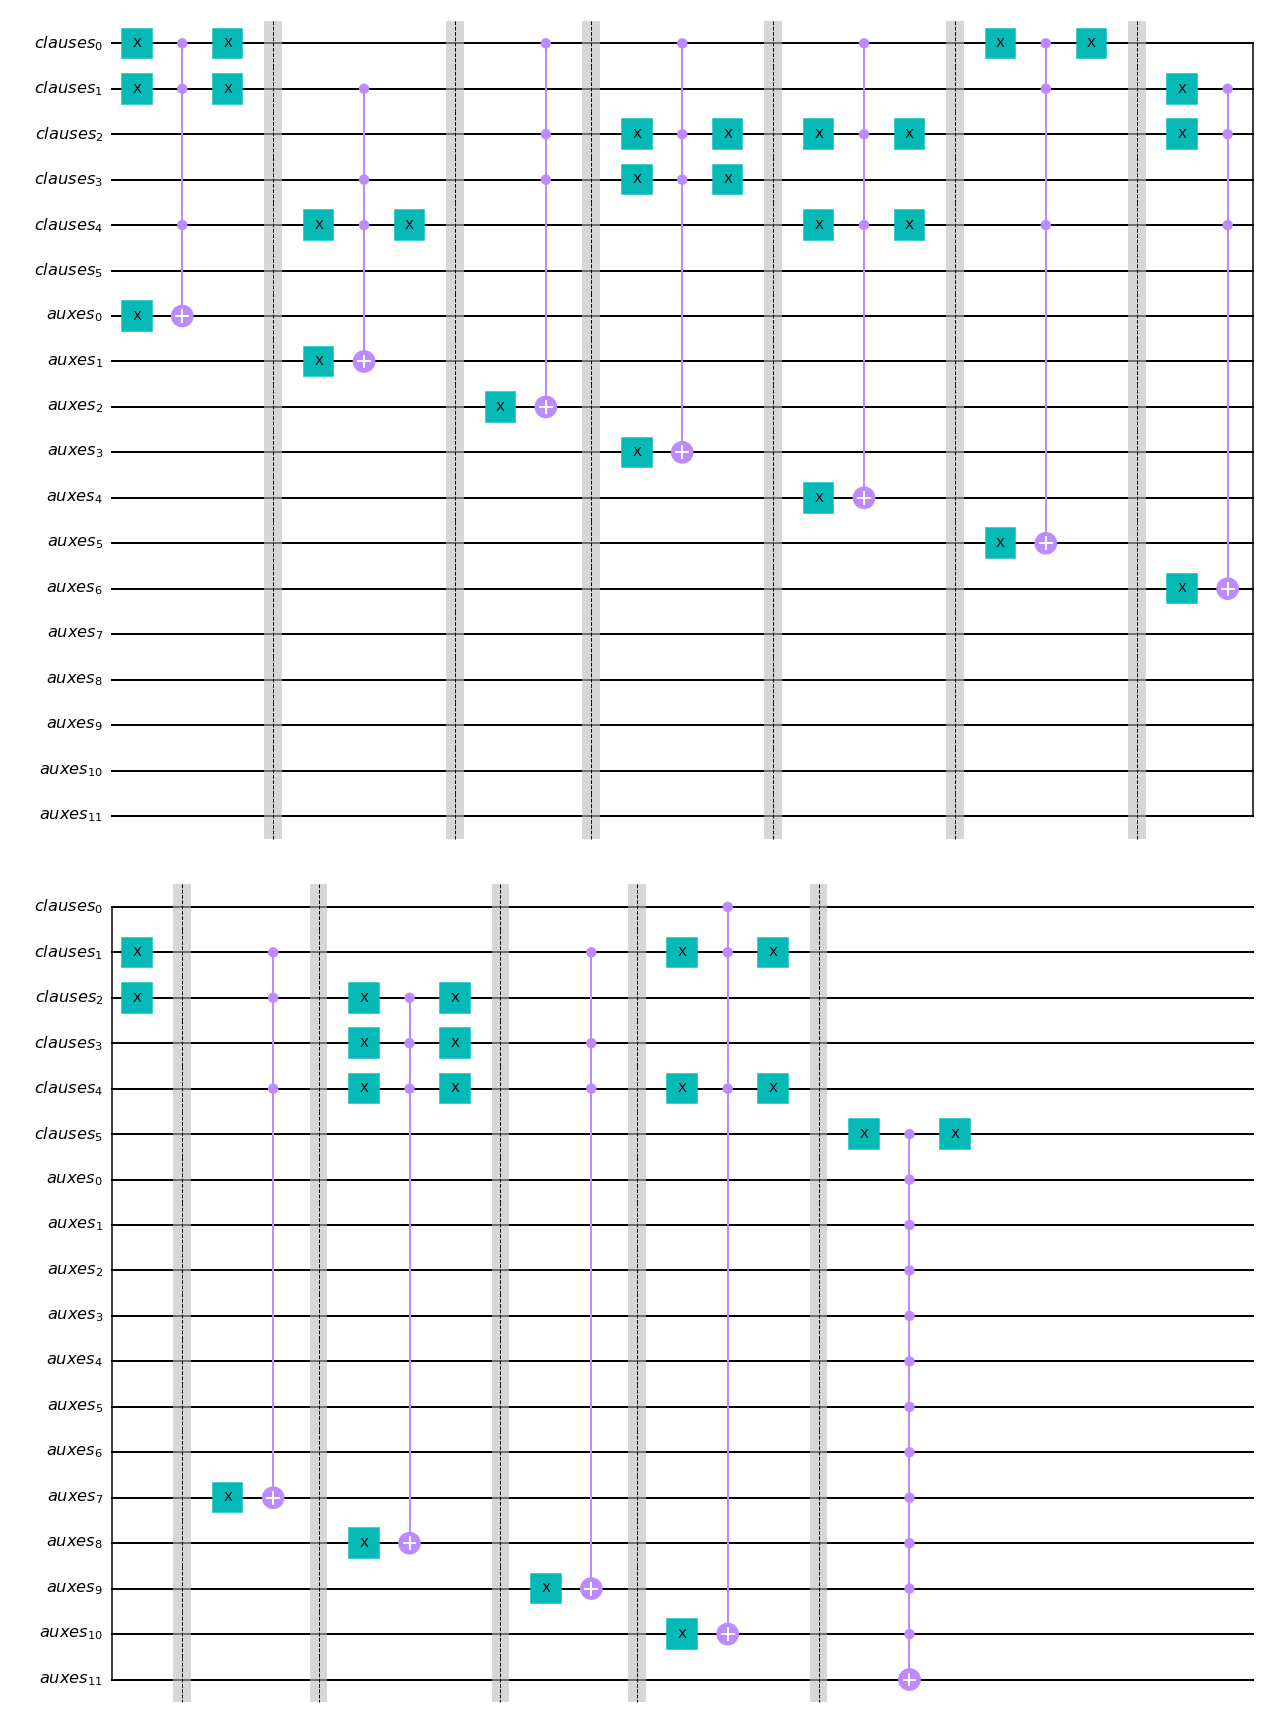

In [4]:
U.draw('mpl', filename='graph.png')


In [5]:
solutions = 0
soln_list = []
non_soln_list =[]
for i in range(2 ** n):
    vals = []
    for j in range(n):
        vals.append((i >> j) & 1)

    result = 1
    for j in range(num_clauses):
        first = vals[expression[j][0]] ^ not_list[j*3]
        second = vals[expression[j][1]] ^ not_list[j*3 + 1]
        third = vals[expression[j][2]] ^ not_list[j*3 + 2]
        result &= (first | second | third)
    if result:
        solutions += 1
        print(vals[::-1])
        soln_list.append(vals[::-1])
    else:
        non_soln_list.append(vals[::-1])
print(f'num_solutions is {solutions}')
print(not_list)
print(expression)

[0, 0, 1, 0, 0]
[0, 0, 1, 1, 0]
[0, 0, 1, 1, 1]
[0, 1, 0, 0, 0]
[0, 1, 1, 0, 0]
[1, 0, 1, 0, 1]
num_solutions is 6
[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
[[1, 4, 0], [4, 3, 1], [0, 3, 2], [3, 0, 2], [2, 4, 0], [1, 0, 4], [1, 2, 4], [2, 1, 4], [2, 4, 3], [3, 4, 1], [0, 1, 4]]


In [6]:
#running grovers
x = QuantumRegister(n + 1, name='x')
auxes = QuantumRegister(aux_num - 1, name='aux')
y = QuantumRegister(1, name='y')
classical = ClassicalRegister(n)
qc = QuantumCircuit(n + 1 + aux_num, n)
last = n + 1 +  aux_num - 1
qc.x(last)
qc.h(last)
qc.barrier()
qc.h(range(n + 1))
adjustment = 0
if solutions > (2**n)/2:
    adjustment += 1
R = math.floor(np.pi * np.sqrt((2 ** (n + adjustment)) / (solutions) / 4))
#print(f'{n}, {solutions}')
print(R)
# test = QuantumCircuit(1,1)
# test.x(0)
# qc.compose(U, inplace=True)
qc.barrier()
for i in range(R):
    qc.compose(U, inplace=True)
    #w
    qc.barrier()
    qc.barrier()

    for j in range(0, n + 1):
        qc.h(j)
        qc.x(j)
    qc.barrier()
    qc.h(0)
    qc.mcx(list(range(1, n + 1)), 0)
    qc.h(0)
    qc.barrier()
    for j in range(n + 1):
        qc.x(j)
        qc.h(j)
    qc.barrier()
#qc.z(range(n + aux_num))
qc.barrier()
qc.h(last)
qc.x(last)
#qc.p(np.pi, last)
qc.barrier()
qc.measure(range(n), range(n))
#qc.draw('mpl')

3


{'01110': 30, '11011': 33, '00010': 43, '11010': 41, '10001': 27, '01010': 38, '10011': 45, '11111': 37, '10010': 36, '10110': 49, '10000': 30, '10101': 177, '11110': 32, '11100': 29, '11101': 47, '10100': 33, '01101': 40, '00001': 37, '01001': 30, '00101': 42, '01100': 171, '00110': 189, '00011': 32, '00100': 187, '01000': 178, '01011': 26, '00000': 38, '00111': 229, '11001': 33, '10111': 33, '11000': 22, '01111': 34}
[[0, 0, 1, 0, 0], [0, 0, 1, 1, 0], [0, 0, 1, 1, 1], [0, 1, 0, 0, 0], [0, 1, 1, 0, 0], [1, 0, 1, 0, 1]]


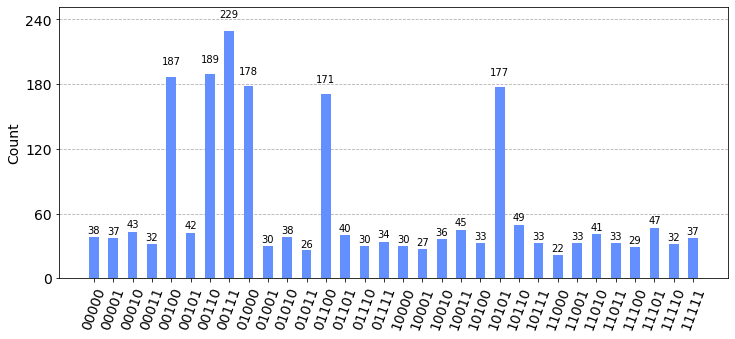

In [11]:
#Simulate your circuit!
backend = Aer.get_backend('qasm_simulator')
counts= execute(qc,backend, shots=2048).result().get_counts(qc)
print(counts)
print(soln_list)
plot_histogram(counts, figsize=(12, 5))

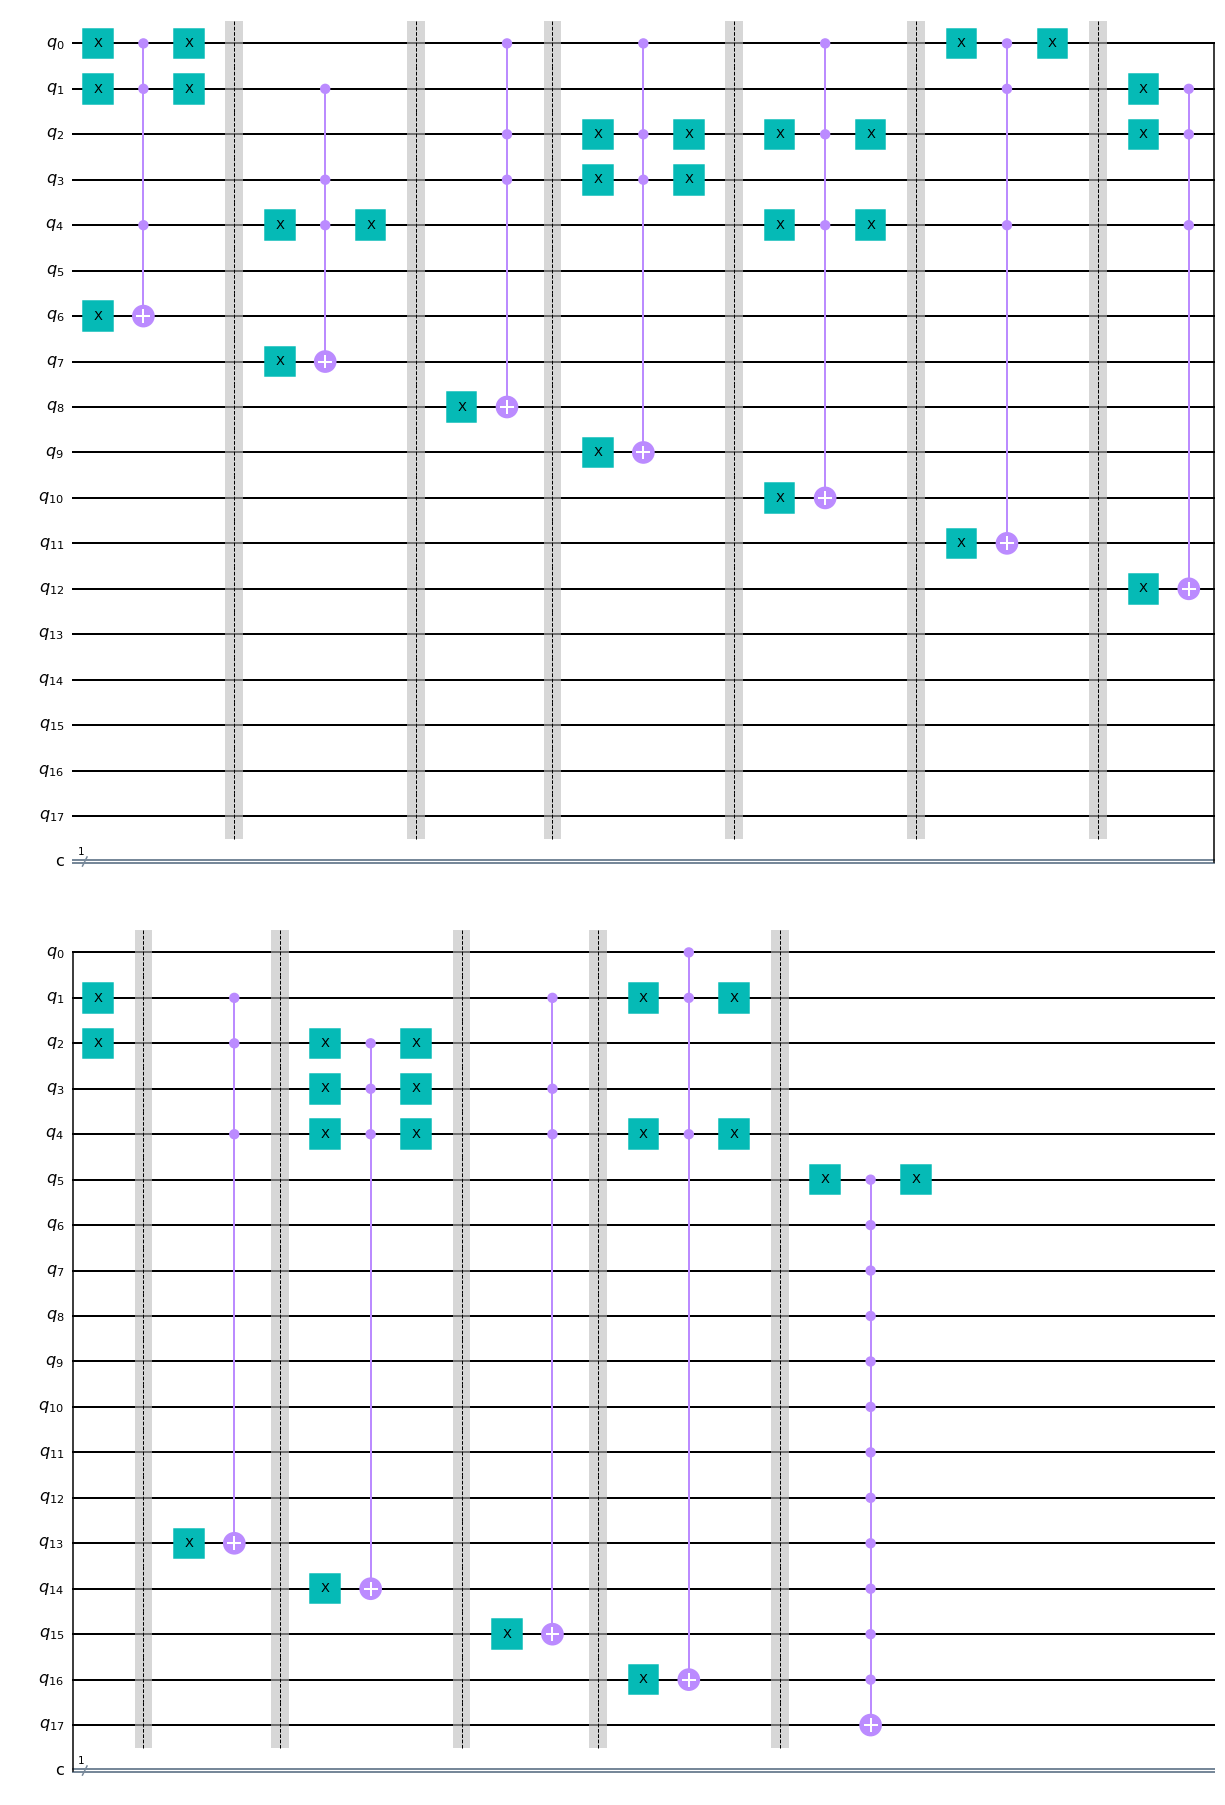

In [8]:
testc = QuantumCircuit(n + 1 + aux_num, 1)
testc.compose(U, inplace=True)
testc.draw('mpl')


In [12]:
for soln in soln_list:
    testc = QuantumCircuit(n + aux_num + 1, 1)
    for i in range(len(soln)):
        if soln[i]:
            testc.x(n - 1 - i)
    testc.barrier()
    testc.compose(U, inplace=True)
    testc.measure(n + aux_num, 0)
    backend = Aer.get_backend('qasm_simulator')
    counts = execute(testc,backend, shots=1024).result().get_counts(testc)
    print(str(soln) + ": " + str(counts))
#testc.draw('mpl')
print()
for soln in non_soln_list:
    testc = QuantumCircuit(n + 1 + aux_num, 1)
    for i in range(len(soln)):
        if soln[i]:
            testc.x(n - 1 - i)
    testc.barrier()
    testc.compose(U, inplace=True)
    testc.measure(n + aux_num, 0)
    backend = Aer.get_backend('qasm_simulator')
    counts = execute(testc,backend, shots=1024).result().get_counts(testc)
    print(str(soln) + ": " + str(counts))


[0, 0, 1, 0, 0]: {'1': 1024}
[0, 0, 1, 1, 0]: {'1': 1024}
[0, 0, 1, 1, 1]: {'1': 1024}
[0, 1, 0, 0, 0]: {'1': 1024}
[0, 1, 1, 0, 0]: {'1': 1024}
[1, 0, 1, 0, 1]: {'1': 1024}

[0, 0, 0, 0, 0]: {'0': 1024}
[0, 0, 0, 0, 1]: {'0': 1024}
[0, 0, 0, 1, 0]: {'0': 1024}
[0, 0, 0, 1, 1]: {'0': 1024}
[0, 0, 1, 0, 1]: {'0': 1024}
[0, 1, 0, 0, 1]: {'0': 1024}
[0, 1, 0, 1, 0]: {'0': 1024}
[0, 1, 0, 1, 1]: {'0': 1024}
[0, 1, 1, 0, 1]: {'0': 1024}
[0, 1, 1, 1, 0]: {'0': 1024}
[0, 1, 1, 1, 1]: {'0': 1024}
[1, 0, 0, 0, 0]: {'0': 1024}
[1, 0, 0, 0, 1]: {'0': 1024}
[1, 0, 0, 1, 0]: {'0': 1024}
[1, 0, 0, 1, 1]: {'0': 1024}
[1, 0, 1, 0, 0]: {'0': 1024}
[1, 0, 1, 1, 0]: {'0': 1024}
[1, 0, 1, 1, 1]: {'0': 1024}
[1, 1, 0, 0, 0]: {'0': 1024}
[1, 1, 0, 0, 1]: {'0': 1024}
[1, 1, 0, 1, 0]: {'0': 1024}
[1, 1, 0, 1, 1]: {'0': 1024}
[1, 1, 1, 0, 0]: {'0': 1024}
[1, 1, 1, 0, 1]: {'0': 1024}
[1, 1, 1, 1, 0]: {'0': 1024}
[1, 1, 1, 1, 1]: {'0': 1024}
